In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [374]:
plt.rc("font",size=14)

In [112]:
days = [20,21,28,29,30]

## i/o

In [186]:
    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/UST_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_ust = pd.read_csv(fname, index_col=[0], parse_dates=True)

In [219]:
for iday,day in enumerate(days):

    start = pd.to_datetime('2015-{0}-{1} 14:10'.format(3,day))
    end   = pd.to_datetime('2015-{0}-{1} 23:50'.format(3,day))
    idx   = pd.date_range(start=start, end=end, freq='10min')  
    idx.freq=None
    
    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/UST_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_ust = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_ust = df_ust.reindex(index=idx)
    df_ust = pd.Series(index=df_ust.index,data=np.ravel(df_ust.values))

    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/HFX_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_hfx = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_hfx = df_hfx.reindex(index=idx)
    df_hfx = pd.Series(index=df_hfx.index,data=np.ravel(df_hfx.values))
    
    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/PBLH_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_zi = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_zi.index = df_zi.index.tz_localize(None)
    df_zi = pd.Series(index=df_zi.index,data=df_zi['median'].values)
    df_zi = df_zi.reindex(index=idx)

    df_theta = df_zi.copy() * 0.0 + 300.0

    df_wst = ((9.81/df_theta)* df_zi * df_hfx)**(1/3.)

    if iday==0:
        df_ust_final = df_ust.copy()
        df_wst_final = df_wst.copy()
        df_zi_final  = df_zi.copy()
    else:
        df_ust_final = pd.concat([df_ust_final,df_ust],axis=0)
        df_wst_final = pd.concat([df_wst_final,df_wst],axis=0)    
        df_zi_final  = pd.concat([df_zi_final,df_zi],axis=0)            

## functions

In [401]:
def p_nl(delta_star,C_cs=None,ust=None,wst=None):
    
    # Hyeyum Hailey Shin and Song-You Hong, “Representation of the Subgrid-Scale Turbulent Transport in Convective Boundary Layers at Gray-Zone Resolutions,” Monthly Weather Review 143, no. 1 (January 1, 2015): 250–71, https://doi.org/10.1175/MWR-D-14-00116.1.
    # Eqs. [2] & [3]
    
    if C_cs==None:
        a_cs = 0.5
        b_cs = -40.0
        c_cs = -0.5
        d_cs = 8.0
        e_cs = 3.0

        arg           = b_cs * np.abs(ust/wst+c_cs) + d_cs
        C_cs          = a_cs * (np.tanh(arg)+e_cs)    

    delta_star_cs = delta_star/C_cs
    
    top = delta_star_cs**2 + 0.936*delta_star_cs**(7/8.) - 1.110
    bot = delta_star_cs**2 + 0.312*delta_star_cs**(7/8.) + 0.329
    
    return C_cs,0.243*top/bot+0.757

def p_l(delta_star):
    
    # Hyeyum Hailey Shin and Song-You Hong, “Representation of the Subgrid-Scale Turbulent Transport in Convective Boundary Layers at Gray-Zone Resolutions,” Monthly Weather Review 143, no. 1 (January 1, 2015): 250–71, https://doi.org/10.1175/MWR-D-14-00116.1.
    # Eq. [7]
  
    top = delta_star**2 + 0.870*delta_star**(0.5) - 0.913
    bot = delta_star**2 + 0.153*delta_star**(0.5) + 0.278

    return 0.280*top/bot+0.720

## theoretical values

In [398]:
delta_star = np.arange(0.0,10.01,0.01)
local      = p_l(delta_star)
non_local  = p_nl(delta_star,C_cs=1.0)

## actual values

In [402]:
delta              = 333.0 
delta_star_actual  = delta/df_zi_final

local_actual = p_l(delta_star_actual.values)
C_s, non_local_actual = p_nl(delta_star_actual.values,ust=df_ust_final.values,wst=df_wst_final.values)

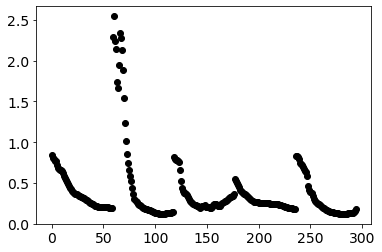

In [403]:
plt.plot(delta_star_actual.values, 'ok')

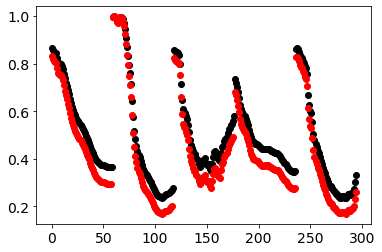

In [404]:
plt.figure()
plt.plot(local_actual,'ok')
plt.plot(non_local_actual,'or')

## get histogram of actual values of p_l and p_nl

In [394]:
bins        = np.arange(-2, 1.01, 0.2)
vals, bins  = np.histogram(np.log10(local_actual), bins=bins, density=False)
perc_vals   = (vals/np.sum(vals) * 100)
bin_centers = (bins[1:]+bins[0:-1])/2

In [395]:
bins              = np.arange(-2, 1.01, 0.2)
vals_nl, bins_nl  = np.histogram(np.log10(non_local_actual), bins=bins, density=False)
perc_vals_nl      = (vals_nl/np.sum(vals_nl) * 100)
bin_centers_nl    = (bins_nl[1:]+bins_nl[0:-1])/2

## get histogram of u*/w* ==> always < 0.1!!!

In [405]:
bins                    = np.arange(0.0, 1.01, 0.1)
vals_stars, bins_stars  = np.histogram(df_ust_final.values/df_wst_final.values, bins=bins, density=False)
perc_vals_stars         = (vals_stars/np.sum(vals_stars) * 100)
bin_centers_stars       = (bins_stars[1:]+bins_stars[0:-1])/2

## plot

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5, 0, 'Horizontal grid spacing relative to boundary layer height\n$\\Delta_*=\\Delta/z_i$ [-]')

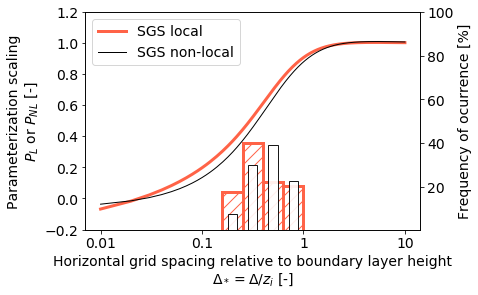

In [400]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(np.log10(delta_star),local,'-',color='tomato',lw=3,label='SGS local')
ax.plot(np.log10(delta_star),non_local,'-k',label='SGS non-local',lw=1,zorder=10)
ax.set_ylim([-0.2,1.2])
ax.set_ylabel("Parameterization scaling\n$P_L$ or $P_{NL}$ [-]")
plt.legend()

ax2 = ax.twinx()
ax2.bar(bin_centers,perc_vals_nl,width=0.2,edgecolor='tomato',ls='-',color='white',lw=3,alpha=1,hatch='//')
ax2.bar(bin_centers,perc_vals,width=0.09,edgecolor='k',color='w',lw=1,alpha=0.9)
ax2.set_ylim([0.5,100])
ax2.set_ylabel("Frequency of ocurrence [%]")

ax.set_xticks([-2,-1,0,1])
ax.set_xticklabels([str(a) for a in [0.01,0.1,1,10]])
ax.set_xlabel("Horizontal grid spacing relative to boundary layer height\n$\Delta_*=\Delta/z_i$ [-]")

# fig.savefig("../figs/PL_PNL.png",dpi=250,bbox_inches="tight")